
# Imports

In [1]:
import numpy as np
from math import ceil

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (20, 6)

#habilita el zoom
# import mpld3
# mpld3.enable_notebook()

# Load audio

El audio que estoy usando es Smell like teen spirit de Nirvana

Características:
* Monocanal
* Frecuencia de muestreo: 22050Hz
* Profundidad: 16bits


In [2]:
from scipy.io import wavfile
sampleRate, audioData = wavfile.read("data/sound/smell.wav")

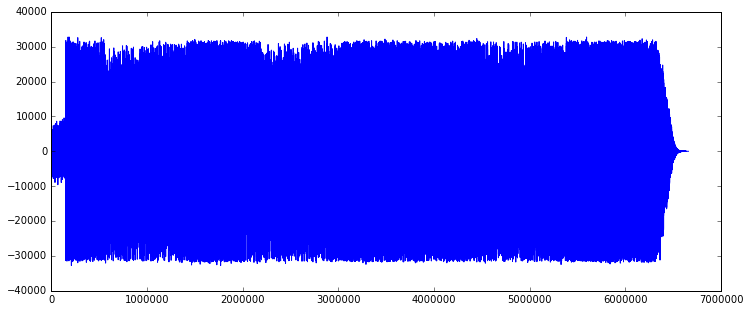

In [31]:
%matplotlib inline
plt.figure(figsize=(12, 5))
plt.plot(audioData)
plt.show()

# Data prep 

Elijo el tamaño de mis muestras de audio y preparo la matriz a utilizar

In [132]:
SEGUNDOS_FILA = 0.2

print("Tomando",SEGUNDOS_FILA,"segundos")
print("Llenando de silencio al final para que me quede cortable...")

newDataSize = audioData.size
while newDataSize % sampleRate != 0:
    newDataSize += 1
    
segundos = newDataSize / sampleRate

while newDataSize % (sampleRate*SEGUNDOS_FILA) != 0:
    newDataSize += sampleRate

print("Longitud (s) de la cancion:", newDataSize / sampleRate)

audioData.resize(newDataSize)

#lo paso a matriz, tipo dataset
matrixAudioData = audioData.reshape( ( int(newDataSize/ (sampleRate*SEGUNDOS_FILA) ), int(sampleRate * SEGUNDOS_FILA) ))
print("shape de la matriz de audio crudo:", matrixAudioData.shape)


Tomando 0.2 segundos
Llenando de silencio al final para que me quede cortable...
Longitud (s) de la cancion: 302.0
shape de la matriz de audio crudo: (1510, 4410)


### Fast Fourier Transformation (FFT)

Uso las frecuencias de los audios en el dataset para tener variables nuevas relacionadas con la frecuencia de los samples en vez de con la amplitud

In [133]:
from numpy.fft import fft, fftfreq
from math import ceil
#CANT_FRECUENCIES = 2000

print("haciendo fft a cada fila")
i=0
freqAmps = []
cantFq = int(ceil((matrixAudioData[0].size+1)/2.0)) #floor(matrixAudioData[0].size / 2)
for row in matrixAudioData:
    freqs = fft(row)
    # freqAmps = np.vstack( (freqAmps, np.absolute (freqs)) )
    freqAmps.append( np.absolute(freqs[:cantFq]) )
    #freqAmps.append( freqs )
    # plt.figure(i)
    # plt.plot(freqsAmp)
    # i += 1
# plt.show()

freqAmps = np.array(freqAmps)

# https://web.archive.org/web/20120615002031/http://www.mathworks.com/support/tech-notes/1700/1702.html
# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
# scale by the number of points so that
# the magnitude does not depend on the length 
# of the signal or on its sampling frequency
for row in freqAmps:
    row = row / float( matrixAudioData[0].size )
    row = row**2 # square it to get the power 


#abria que hacerlo por row ?
# multiply by two (see technical document for details)
# odd nfft excludes Nyquist point
#if cantFq % 2 > 0: # we've got odd number of points fft
#    freqAmps[1:len(freqAmps)] = freqAmps[1:len(freqAmps)] * 2
#else:
#    freqAmps[1:len(freqAmps) -1] = freqAmps[1:len(freqAmps) - 1] * 2 # we've got even number of points fft



# print("freqAmps", freqAmps.shape)

#matrixAudioData = np.hstack((matrixAudioData, freqAmps))
matrixAudioDataNoFFT = np.copy(matrixAudioData)
matrixAudioData = freqAmps
#print("matriz final con audio crudo y fft", matrixAudioData.shape)
print("matriz final sólo con fft", matrixAudioData.shape)

haciendo fft a cada fila
matriz final sólo con fft (1510, 2206)


In [117]:
(matrixAudioData[0]).size

2206

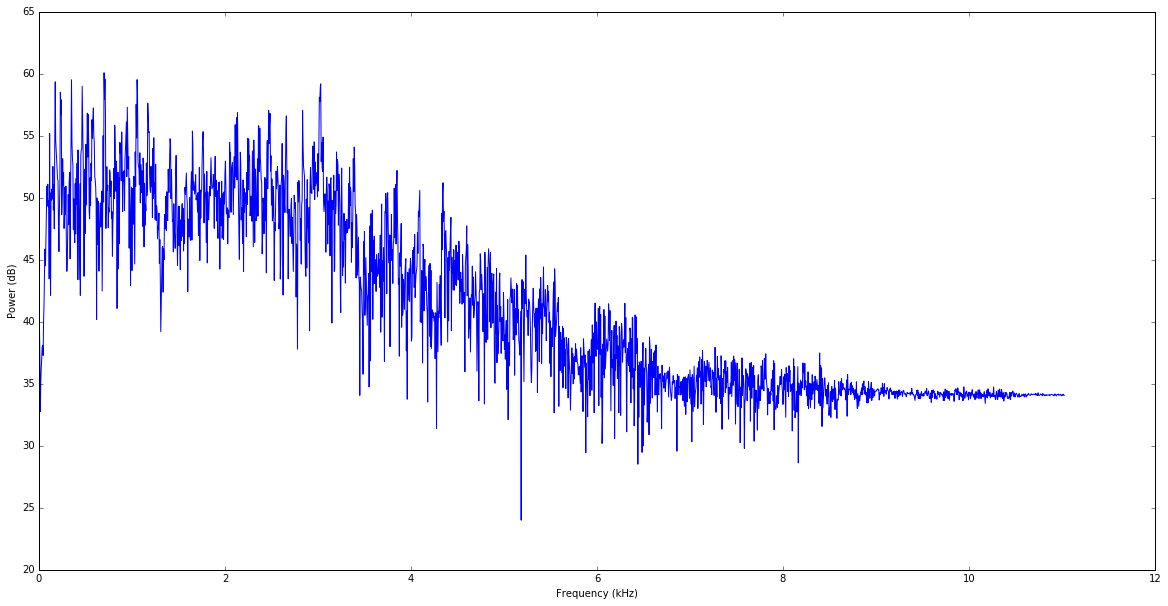

In [134]:

sampleIndex = 10

freqArray = np.arange(0, cantFq, 1.0) * (22050 / matrixAudioDataNoFFT[0].size);

plt.figure(figsize=(20,10))

plt.plot(freqArray/1000, 10*np.log10(matrixAudioData[sampleIndex]))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')


#plt.bar(range(0, CANT_FREQS),matrixAudioData[4,:CANT_FREQS])
plt.show()

In [137]:
rms_val = np.sqrt(np.mean(matrixAudioDataNoFFT[sampleIndex]**2))
print(rms_val)
rms_val = np.sqrt(np.sum(matrixAudioData[sampleIndex]))
print(rms_val)

22.7376040835
10460.3878532


In [81]:
 sd.play(matrixAudioDataNoFFT[4], 22050, blocking = True)

# Principal Component Analysis

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200) #asi explicaba 95%
# pca = PCA(n_components=22050)
pca.fit(matrixAudioData)
print("Variance explained:", pca.explained_variance_ratio_.sum())
matrixAudioDataTransformed = pca.transform(matrixAudioData)
# print(matrixAudioDataTransformed[0])
print("shape transformed:", matrixAudioDataTransformed.shape)

Variance explained: 0.958544797969
shape transformed: (1510, 200)


# Cluster Jerárquico

In [39]:
from scipy.cluster import hierarchy as h
from scipy.spatial import distance as dist

distanceFunction = 'canberra'
#linkageType = 'average'
linkageType = 'average'

distanceMatrix = dist.pdist(matrixAudioDataTransformed, distanceFunction) #canberra (0.8), cityblock (0.76), braycurtis(0.77)
clusters = h.linkage(distanceMatrix, linkageType)


c,d=h.cophenet(clusters, distanceMatrix) #factor cofonético
print("distancia:",distanceFunction)
print("linkage:",linkageType)
print("cofonetica:",c)

distancia: canberra
linkage: average
cofonetica: 0.665715228769


### Dendograma

In [46]:
THRESHOLD = 146.2
#THRESHOLD = 56

cutTree = h.cut_tree(clusters, height= THRESHOLD)
# minutos = 0
# segundos = 0
# for label in cutTree:
#     print(str(minutos) + ":" + str(segundos), str(label))
#     segundos += SEGUNDOS_FILA
#     if ( segundos >= 60 ):
#         minutos += 1
#         segundos -= 60

# print(clusters.shape)
# print(clusters)
# exit()

#matrixAudioDataAndCluster = np.hstack((matrixAudioDataTransformed, cutTree))

cantClusters = np.unique(cutTree).size
print("Cantidad de clusters:", cantClusters)

Cantidad de clusters: 6


<IPython.core.display.Javascript object>


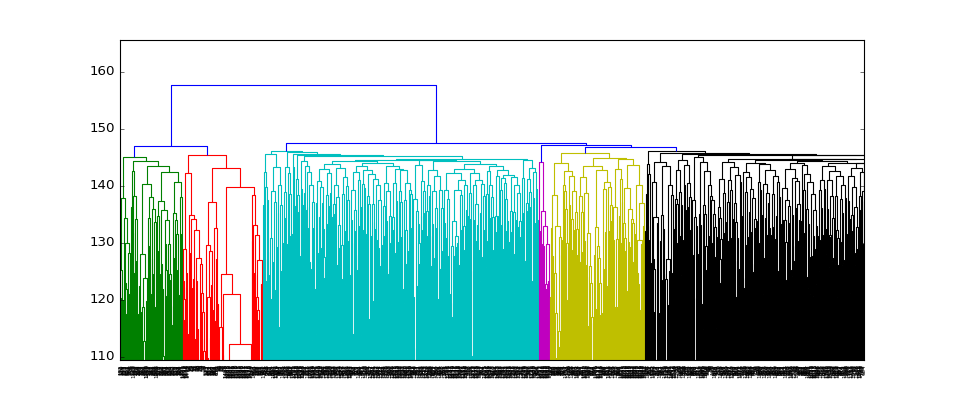

In [47]:
%matplotlib notebook

plt.figure(figsize=(12, 5))
dn = h.dendrogram(clusters, color_threshold = THRESHOLD)
plt.show()

### Histograma

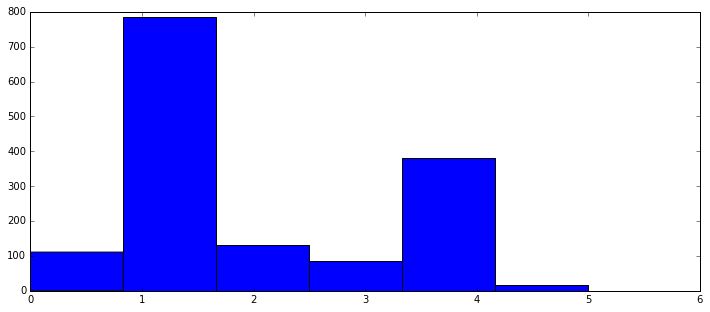

Count:
[ 111.  786.  131.   86.  380.   16.]


In [48]:
%matplotlib inline

plt.figure(figsize=(12, 5))
n = plt.hist(cutTree, bins=cantClusters)[0]
plt.show()
print("Count:")
print(n)

# Multi-dimensional scaling

In [49]:
#check http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html

from sklearn.manifold import MDS 
from sklearn.metrics import pairwise_distances

#similarities = pairwise_distances(matrixAudioDataTransformed, metric = distanceFunction, n_jobs = -1)
similarities = pairwise_distances( dist.squareform(distanceMatrix), n_jobs = -1)

mds = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1) #max_iter=3000, eps=1e-9, 
positions = mds.fit(similarities).embedding_
#positions = mds.fit(distanceMatrix).embedding_
print("Positions shape:", positions.shape)

Positions shape: (1510, 2)


### Scatterplot

<IPython.core.display.Javascript object>


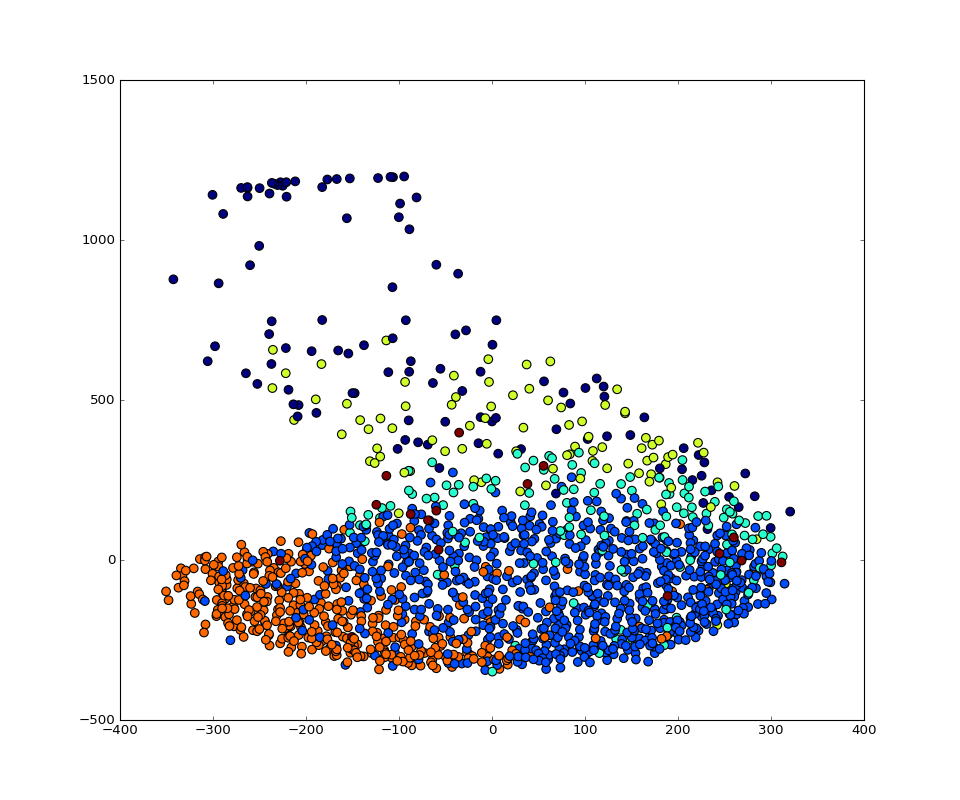

In [138]:
# para debuggear
#
# import sys
# nb_stdout = sys.stdout
# sys.stdout = open('/dev/stdout', 'w')

%matplotlib notebook

import sounddevice as sd

def pointClicked(event):
    sound = None
    
    if ( event.xdata == None ):
        return
    
    for i in range(0, positions.shape[0]):
        if dist.euclidean( positions[i,:], np.array( (event.xdata,event.ydata) ) ) < 10:
            #sound = matrixAudioData[i]
            sound = matrixAudioDataNoFFT[i]
            
    if sound != None:
        sd.play(sound, 22050, blocking = True)

fig = plt.figure(figsize=(12, 10))
plt.scatter(positions[:,0], positions[:,1], s=60, c=cutTree)
fig.canvas.mpl_connect('button_press_event', pointClicked )             
plt.show()

# CSV export

Armo un csv con el audio, el x e y y el número de cluster

In [11]:
import csv

outCsv = np.hstack((positions, cutTree))

